# Vehicle Detection & Tracking Using Computer Vision And Machine Learning

Blablabla....

In [12]:
# Main imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
from importlib import reload
import utils; reload(utils)
from utils import *

In [14]:
test_imgs_dir = "test_images"
output_imgs_dir = "output_images"
output_videos_dir = "output_videos"

project_dataset_dir = "project_dataset"
project_dataset_vehicles_dir = "project_dataset/vehicles"
project_dataset_non_vehicles_dir = "project_dataset/non-vehicles"

# Dataset exploration

In [15]:
# Let's fetch the paths of training images
project_vehicle_img_paths = glob.glob(project_dataset_vehicles_dir + "/**/*.png", recursive=True)
len(project_vehicle_img_paths)

8792

In [16]:
project_non_vehicle_img_paths = glob.glob(project_dataset_non_vehicles_dir + "/**/*.png", recursive=True)
len(project_non_vehicle_img_paths)

8968

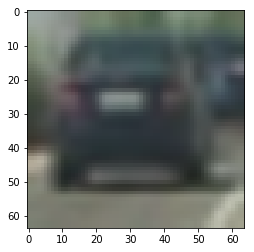

In [17]:
example_img = load_image(project_vehicle_img_paths[0])
plt.imshow(example_img)

In [13]:
class Dataset:
    """
    Represents top level information about a given dataset
    """
    def __init__(self, data_paths, labels, image_size, image_type="png"):
        self.data_paths = data_path
        self.labels = labels
        self.image_size = image_size
        self.image_type = image_type
    
    def load_data(self):
        """
        Identifies all files in the dataset and loads the images
        """
        if len(self.labels) != len(self.data_paths):
            print("Mismatch in length")
            # TODO to continue

# Feature Extraction

In this section, we apply Histogram of Oriented Gradients and Color bins to our input image to create our features, which will then be fed to a classifier. But before we employ these techniques, we must first define a function to subsample our input.

In [35]:
def subsample_image(img, new_size=(32,32), single_vector=True):
    """
    Resizes the image to the new size and returns either a 1-D vector or multi-dimensional matrix depending
    on the value of single_vector
    """
    features = cv2.resize(img, new_size)
    return features.ravel() if single_vector else features

In [36]:
def change_color_space(img, cspace="RGB"):
    """
    Takes in a RGB image and returns a new image in the target color space.
    If the current image and target image are both rgb, then a new copy of the image is returned
    """
    feature_image = None
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    else: 
        feature_image = np.copy(img) 
    
    return feature_image

In [37]:
def color_histogram(img, nbins=32, bins_range=(0, 256)):
    """
    Returns the histograms of the color image across all channels, as a concatenanted feature vector
    """
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [38]:
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler

# hog(to_grayscale(example_img), orientations=orient,
#                           pixels_per_cell=(pix_per_cell, pix_per_cell), 
#                           cells_per_block=(cell_per_block, cell_per_block), 
#                           visualise=True, feature_vector=False,
#                           block_norm="L2-Hys")

In [243]:
def compute_features(img, color_space="RGB", subsample_size=(32, 32), hist_bins=32, hist_range=(0, 256), 
                    hog_orient=6, hog_pix_per_cell=6, hog_cells_per_block=2, hog_block_norm="L2-Hys",
                    hog_color_channels=[0, 1, 2], hog_grayscale=True):
    img_cspace = change_color_space(img, cspace=color_space)
    img_sub_sample = subsample_image(img_cspace, new_size=subsample_size)
    img_color_hist = color_histogram(img, nbins=hist_bins, bins_range=hist_range)

    hog_features = []
    if hog_color_channels == None:            
        hog_features, img_hog = hog(to_grayscale(img), 
                      pixels_per_cell=(hog_pix_per_cell, hog_pix_per_cell), 
                     cells_per_block=(hog_cells_per_block, hog_cells_per_block),
                     block_norm=hog_block_norm, visualise=True, feature_vector=True)
    else:
        for ch in hog_color_channels:
            hf, img_hog = hog(img[:,:,ch], 
                      pixels_per_cell=(hog_pix_per_cell, hog_pix_per_cell), 
                     cells_per_block=(hog_cells_per_block, hog_cells_per_block),
                     block_norm=hog_block_norm, visualise=True, feature_vector=True)
            hog_features = hf if len(hog_features) == 0 else np.concatenate((hog_features, hf))
    
    features = np.concatenate((img_sub_sample, img_color_hist, hog_features))
    # Now stack the features on top of one another for normalization
    #stacked_features = np.vstack([img_sub_sample, img_color_hist, hog_features]).astype(np.float64)
    
    # Normalise all features
    #norm_scaler = StandardScaler().fit(stacked_features)
    #normed_features = norm_scaler.transform(stacked_features)
    
    
    return features

In [244]:
def normalise_features(features, normaliser=None):
    """
    Returnes the tuple (normalised_features, normaliser), 
    where normaliser can normalise future data by applying the function normaliser.transform(data).
    The function can accept a default normaliser. If none is provided, one will be created and returned
    """
    stacked_features = np.vstack(features).astype(np.float64)
    if normaliser == None:        
        normaliser = StandardScaler().fit(stacked_features)
    normed_features = normaliser.transform(stacked_features)
    
    return normed_features, normaliser

# Classification

In [241]:
# Define pipeline read images with label
# Must return the tuple features, labels where we have as many labels as features

# Then normalise all the features together

def extract_dataset_features(classes_imgs, labels):
    all_features = []
    all_labels = []
    for i, class_imgs in enumerate(classes_imgs):
        class_features = []
        class_labels = np.repeat(labels[i], len(class_imgs))
        all_labels = class_labels if len(all_labels) == 0 else np.concatenate((all_labels, class_labels))
        for class_img_path in class_imgs:
            img = load_image(class_img_path)
            img_features = compute_features(img)
            #class_features = img_features if len(class_features) == 0 else np.concatenate((class_features, img_features))
            class_features.append(img_features)

        all_features.append(class_features)
    
    normed_features, normaliser = normalise_features(all_features)
    
#     y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    return normed_features, all_labels, normaliser    
            


In [245]:
data_features, data_labels, normaliser = extract_dataset_features([project_vehicle_img_paths, project_non_vehicle_img_paths], ["vehicle", "non_vehicle"])

KeyboardInterrupt: 

In [181]:
len(data_features)

17760

In [182]:
len(data_labels)

17760

In [72]:
data_features.shape

(2000, 6084)

In [108]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [143]:
def split_dataset(data, labels, test_pct=0.2):
    """
    Splits the dataset into with training having a proportion of 1 - test_pct, and the test set with propotion test_pct 
    Returns the tuple (X_train, y_train), (X_test, y_test)
    """
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_pct)
    return (X_train, y_train), (X_test, y_test)

In [144]:
def train_classifier(data, labels, method="SVM"):
    """
    Train a classifier on the data and labels and returns the trained classifier
    The classifier itself can be chosen from a variety of options. The default is SVM    
    """
    cfier = None
    if method == "SVM":
        svc = LinearSVC()
        svc.fit(data, labels)
        cfier = svc
    
    return cfier
    

In [183]:
training_dataset, test_dataset = split_dataset(data_features, data_labels)

In [146]:
training_dataset[0].shape

(4800, 6084)

In [184]:
classifier = train_classifier(training_dataset[0], training_dataset[1])

In [186]:
preds = classifier.predict(test_dataset[0])

In [187]:
accuracy_score(test_dataset[1], preds)

0.9755067567567568

# Pipeline

## Sliding Windows

In [136]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """
    Returns a new image the bounding boxes have been overlaid in the chosen color
    """
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [172]:
def sliding_windows(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """
    Computes the all possible sliding windows for the given image and window parameters
    Returns the positions of the computed sliding windows
    """
    width, height = img.shape[1], img.shape[0]
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = width
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = height
    
    # How many windows would we have if we only took into account window size
    
    
    # What is the actual overlap in total number of pixels
    x_overlap = np.int(xy_window[0] * xy_overlap[0])
    y_overlap = np.int(xy_window[1] * xy_overlap[1])
    
    section_width = x_start_stop[1] - x_start_stop[0]
    section_height = y_start_stop[1] - y_start_stop[0]
    print("s_width=", section_width, " x_overlap=", x_overlap)
# Using the formula from convolutions (cf. cs231n)
# = W - Conv  (+2P) / Stride + 1 -> Since padding is 0, 2P = 0
    x_total_windows = np.int(((section_width - xy_window[0])  / x_overlap) + 1)
    print("x_total_windows: ", x_total_windows)
    y_total_windows = np.int(((section_height - xy_window[1])  / y_overlap) + 1)
    print("y_total_windows: ", y_total_windows)
    
    found_windows = []
    for y in range(0, y_total_windows):
        y_offset = y * y_overlap + y_start_stop[0]
        for x in range(0, x_total_windows):
            x_offset = x * x_overlap + + x_start_stop[0]
            
            top_left = (x_offset, y_offset)
            bottom_right = (x_offset + xy_window[0], y_offset + xy_window[1])
            
            found_windows.append((top_left, bottom_right))
                
    
    return found_windows

In [117]:
test_imgs_paths = glob.glob(test_imgs_dir + "/*.jpg", recursive=True)

In [120]:
test_imgs = np.asarray(list(map(lambda img_path: load_image(img_path), test_imgs_paths)))

In [122]:
test_imgs[0].shape

(720, 1280, 3)

In [230]:
# Strive to maintain the aspect ratio
s_windows = sliding_windows(test_imgs[0], x_start_stop=[384, None], y_start_stop=[350, None], xy_window=(64, 32))

s_width= 896  x_overlap= 32
x_total_windows:  27
y_total_windows:  22


In [231]:
test_img_boxes = draw_boxes(test_imgs[0], s_windows)

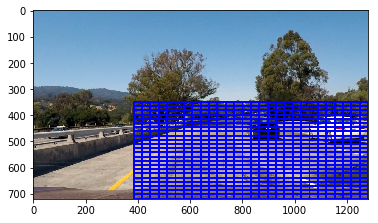

In [232]:
plt.imshow(test_img_boxes)

## Running Classifier On Windows

In [218]:
def find_hot_windows(img, sl_windows, normaliser, classifier, correct_prediction):
    """
    Identifies windows where our classifier "fired" a positive prediction    
    """
    hot_windows = []
    features = []
    for sl_window in sl_windows:
        top_left = sl_window[0]
        bottom_right = sl_window[1]
        img_window = img[top_left[1]:bottom_right[1],top_left[0]:bottom_right[0],:]
        img_window_resized = subsample_image(img_window, new_size=(64, 64), single_vector=False)
        img_window_features = compute_features(img_window_resized)
#        img_window_features_normalised = normaliser.transform(img_window_features)
        features.append(img_window_features)
#         prediction = classifier.predict(img_window_features_normalised.reshape(-1, 1))
#         print(prediction)
#         if prediction == correct_prediction:
#             hot_windows.append(sl_window)
        
    features_normalised, _ = normalise_features(features, normaliser=normaliser)
    predictions = classifier.predict(features_normalised)
    
    for (sl_window, pred) in zip(sl_windows, predictions):
        if pred == correct_prediction:
             hot_windows.append(sl_window)
    
    return hot_windows

In [233]:
h_wins = find_hot_windows(test_imgs[0], s_windows, normaliser, classifier, "vehicle")

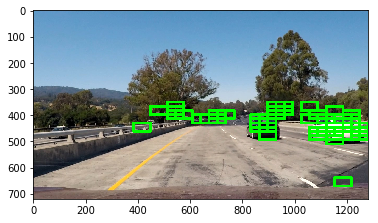

In [234]:
img_hot_windows = draw_boxes(test_imgs[0], h_wins, color=(0, 255, 0), thick=10)
plt.imshow(img_hot_windows)

## Heatmap Thresholding

In [202]:
from scipy.ndimage.measurements import label

In [201]:
def create_heatmap(img, bbox_list):
    """
    Returns a new heatmap where the regions of the image captured by the bounding boxes are "heated-up"
    """
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    heatmap = np.clip(heatmap, 0, 255)

    return heatmap

In [200]:
def threshold_heatmap(heatmap, threshold=2):
    """
    Updates the heatmap by only retaining hot sections whose values are strictly above the threshold.
    All other values are "cooled" down
    """
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [203]:
def label_heatmap(heatmap):
    """
    Returns a slice with labels over the original heatmap, as well as the total count of labels found
    """
    return label(heatmap)

In [208]:
def draw_smoothed_boxes(img, labels, duplicate=True):
    """
    Returns an image where bounding boxes have been drawn around the areas labeled.
    """
    
    copy = np.copy(img) if duplicate else img
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(copy, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return copy

In [237]:
def smoothen_bounding_boxes(img, bboxes, thres=2):
    
    heat = create_heatmap(img, bboxes)
    heat_thresholded = threshold_heatmap(heat, threshold=thres)
    heat_labels = label_heatmap(heat_thresholded)
    img_smoothed_bboxes = draw_smoothed_boxes(img, heat_labels)
    
    return heat, heat_thresholded, heat_labels, img_smoothed_bboxes

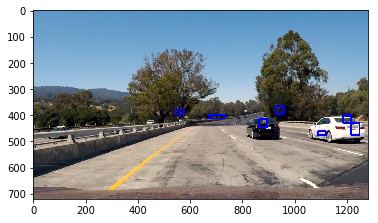

In [238]:
heatmap, heatmap_thres, heatmap_lbs, smoothed_cars_bboxes = smoothen_bounding_boxes(test_imgs[0], h_wins)
plt.imshow(smoothed_cars_bboxes)


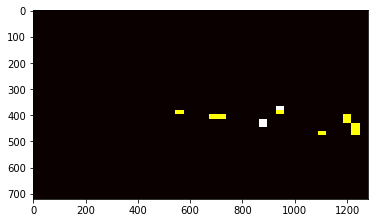

In [239]:
plt.imshow(heatmap, cmap="hot")

In [25]:
pix_per_cell = 6
cell_per_block = 2
orient = 9

In [26]:
features, hog_image = hog(to_grayscale(example_img), orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=False,
                          block_norm="L2-Hys")

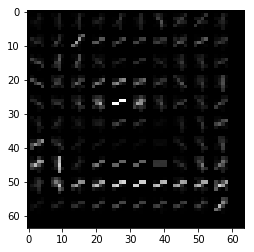

In [27]:
plt.imshow(hog_image, cmap='gray')